Bueno, en algun momento me voy a pregutnar como es que este codigo funciona y eso depende de como lo comente.

Se supone que la primera parte es conseguir estadisticas de un archivo de HRV DATA

Ocupamos la mean y la std de 3 regiones.

Luego, hacemos un diagrama de poincar el cual le debemos sacar SD1 y SD2 para 3  regiones igual.

Ploteamos ambas graficas y las labeleamos.

Insertamos los datos en un csv y listo.

In [3]:
#importando librerias porque si
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict

In [22]:
#Comenzamos con un ejemplo na más
csv_filename = 'Run.csv'
filename = 'All/aca100wD.txt'  # The file you want to process

In [23]:
# Segun el Dr, le ponen zeros a valores que no nos interesan entonces los debemos de extraer para no usarlos
#cargamos el file pues
data = np.loadtxt(filename)
#le hacemos el filtramiento, obteniendo dos columnas,
filtered_data = data[data[:, 1] != 0]  # Filter out zero values
time_data = filtered_data[:, 0] # tiempo (que en si ni ocupamos xd)
hrv_data = filtered_data[:, 1]  # hrv

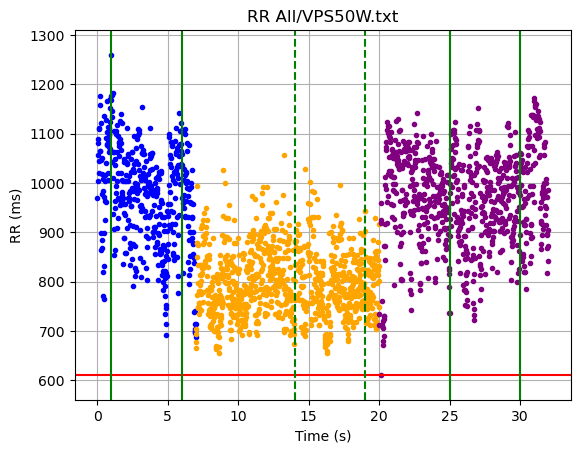

In [12]:
#Vamos a comenzar con las plots primero
#HRV data
# Como digo, tenemos 3 regiones, 
Rest = 7
Exercise = 20
Recovery = 32
colors = {'Rest': 'blue', 'Exercise': 'orange', 'Recovery': 'purple'}

for i in range(len(time_data)):
    if time_data[i] < Rest:
        color = colors['Rest']
    elif time_data[i] < Exercise:
        color = colors['Exercise']
    elif time_data[i] < Recovery:
        color = colors['Recovery']
    else:
        continue
    plt.plot(time_data[i], hrv_data[i], '.', color=color)
    

plt.axhline(y= hrv_data.min(), color='r', linestyle='-')
plt.axvline(x=1, color='g', linestyle='-')
plt.axvline(x=6, color='g', linestyle='-')
plt.axvline(x=14, color='g', linestyle='--')
plt.axvline(x=19, color='g', linestyle='--')
plt.axvline(x=25, color='g', linestyle='-')
plt.axvline(x=30, color='g', linestyle='-')

# Set axis limits, title, labels, and grid
plt.ylim(hrv_data.min() - 50, hrv_data.max() + 50)
plt.title(f"RR {filename}")  # Include filename in title
plt.xlabel("Time (s)")
plt.ylabel("RR (ms)")
plt.grid(True)

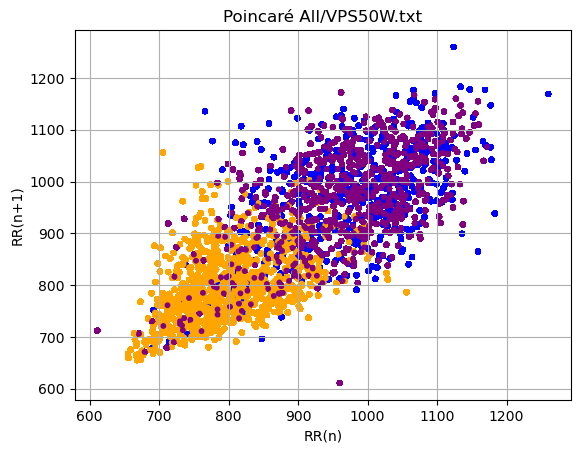

In [13]:
# Ahora la de Poincare
x = []
y = []
colors = {'Rest': 'blue', 'Exercise': 'orange', 'Recovery': 'purple'}
color_x = []
Rest = 7
Exercise = 20
Recovery = 32
for i in range(len(hrv_data) - 1):
    x.append(hrv_data[i])     # RR(n)
    y.append(hrv_data[i + 1]) # RR(n+1)
    # Determine color based on the time of RR(n) and RR(n+1)
    if time_data[i] < Rest:
        color_x.append(colors['Rest'])
    elif time_data[i] < Exercise:
         color_x.append(colors['Exercise'])
    elif time_data[i] < Recovery:
        color_x.append(colors['Recovery'])
    else:
        continue
    plt.scatter(x, y, c=color_x, s=10)  # Use c=color_x directly
    plt.title(f"Poincaré {filename}")  # Include filename in title
    plt.xlabel("RR(n)")
    plt.ylabel("RR(n+1)")
    plt.grid(True)

In [14]:
#Ahora necesitamos las estadisiticas pues

In [15]:
#Esto es para las SD_i de las elipses
def calculate_sd1_sd2(series):
    n = len(series)
    mean_rr = np.mean(series)    
    # Calculate SD1
    diff_rr = np.diff(series) / np.sqrt(2)
    sd1 = np.sqrt(np.sum(diff_rr**2) / (n - 1))
    # Calculate SD2
    sd2_term = (series[:-1] + series[1:] - 2 * mean_rr) / np.sqrt(2)
    sd2 = np.sqrt(np.sum(sd2_term**2) / (n - 1))
    return sd1, sd2

In [24]:
# OBO
intervals = {'Rest': (1, 6),
             'Exercise': (14, 19),
             'Recovery': (25, 30)
            }
stats = {}
for interval, (start, end) in intervals.items():
    mask = (time_data >= start) & (time_data < end)
    interval_data = hrv_data[mask]
    
    if len(interval_data) > 1:  # Ensure there's enough data for SD calculation
        rr_mean = np.mean(interval_data)
        sd1, sd2 = calculate_sd1_sd2(interval_data)
        rr_std = np.std(interval_data)  # Calculate standard deviation
        stats[interval] = {'Mean': rr_mean,
                           'Standard Deviation': rr_std,
                           'SD1': sd1,
                           'SD2': sd2
                          }
stats

{'Rest': {'Mean': 761.5913705583756,
  'Standard Deviation': 55.11587264952379,
  'SD1': 25.90302918810062,
  'SD2': 73.52789042161227},
 'Exercise': {'Mean': 644.2494623655914,
  'Standard Deviation': 25.49649195206052,
  'SD1': 11.473920954449945,
  'SD2': 34.22378195388362},
 'Recovery': {'Mean': 767.1969309462916,
  'Standard Deviation': 59.58852591102106,
  'SD1': 25.023988491045948,
  'SD2': 80.44672618348407}}

'''
Bueno, ahora necesitamos poder poner esto en orden
Primero, necesitamos obtener los nombres en el folder correspondiente y asi poder oredenarlos.
Segundo, necesitamos meter ambas graficas en 1 sola imagen.
Tercero, necesitamos poder alimentar el csv con los datos correctos
Cuarto, necesitamos mover las imagenes a un solo PDF.
'''

In [27]:
data_folder = 'All'

In [28]:
txt_files = glob.glob(os.path.join(data_folder, "*.txt"))
# List all .txt files in the folder
filenames = os.listdir(data_folder)
# Group files by prefix up to the first number
file_groups = defaultdict(list)
pattern = re.compile(r"([a-zA-Z]+)(\d+)")  # Regex to extract the prefix and number
# Process each filename
for filename in filenames:
    match = pattern.match(filename)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))  # Extract the number
        file_groups[prefix].append((filename, number))
# Sort each group by the number part
sorted_filenames = []
for prefix, files in file_groups.items():
    sorted_files = sorted(files, key=lambda x: x[1])  # Sort by the number
    sorted_filenames.extend([file[0] for file in sorted_files])  # Add sorted filenames to the list
print(sorted_filenames)

['hrrv100wD.txt', 'hrrv150wD.txt', 'hrrv200wD.txt', 'hrrv250wD.txt', 'hrrv300wD.txt', 'hrrv350wD.txt', 'GRG50W.txt', 'GRG100W.txt', 'GRG200W.txt', 'GRG250Wtts.txt', 'SYGH100W.txt', 'SYGH150W.txt', 'SYGH200W.txt', 'SYGH250W.txt', 'AOG50W.txt', 'AOG100W.txt', 'AOG150W.txt', 'AOG200W.txt', 'AOG250Wtts.txt', 'eula50wD.txt', 'eula100wD.txt', 'eula150wD.txt', 'eula200wD.txt', 'eula250wD.txt', 'eula300wD.txt', 'eula350wD.txt', 'SFDP50W.txt', 'SFDP50Wtts.txt', 'SFDP100W.txt', 'SFDP250W.txt', 'rrn100wD.txt', 'rrn150wD.txt', 'rrn200wD.txt', 'rrn250wD.txt', 'VPS50W.txt', 'VPS100W.txt', 'VPS150Wtts.txt', 'VPS150W.txt', 'VPS200W.txt', 'VPS250W.txt', 'HJZG50W.txt', 'HJZG100W.txt', 'HJZG150W.txt', 'HJZG200W.txt', 'HJZG250w.txt', 'YARV50W.txt', 'YARV50Wtts.txt', 'YARV100W.txt', 'YARV150W.txt', 'YARV200W.txt', 'MSGM50W.txt', 'MSGM100W.txt', 'MSGM150W.txt', 'MSGM200W.txt', 'MSGM250W.txt', 'SGFU50W.txt', 'SGFU100W.txt', 'SGFU150W.txt', 'SGFU200W.txt', 'SGFU250W.txt', 'SGFU300W.txt', 'SGFU350W.txt', 'MFSC

In [29]:
import csv
import io

# Create a virtual CSV file in memory
virtual_csv = io.StringIO()

# Prepare the CSV writer
writer = csv.writer(virtual_csv)

# Write a single header row
writer.writerow([
    "File", 
    "Mean_RR_Rest", "STD_RR_Rest",
    "Mean_RR_Exercise", "STD_RR_Exercise",
    "Mean_RR_Recovery", "STD_RR_Recovery",
    "SD1_Rest", "SD2_Rest",
    "SD1_Exercise", "SD2_Exercise",
    "SD1_Recovery", "SD2_Recovery"
])

# Optionally, add some rows of data for demonstration
writer.writerow([
    "sample_data.csv",
    970.11, 93.83,  # Rest
    798.25, 68.72,  # Exercise
    957.92, 86.87,  # Recovery
    67.38, 113.79,  # SD1 and SD2 for Rest
    46.73, 85.00,   # SD1 and SD2 for Exercise
    57.68, 108.69   # SD1 and SD2 for Recovery
])

# Get the CSV content
virtual_csv.seek(0)  # Move to the beginning of the virtual file
csv_content = virtual_csv.getvalue()

# Print the CSV content
print(csv_content)

# Close the virtual CSV file
virtual_csv.close()


File,Mean_RR_Rest,STD_RR_Rest,Mean_RR_Exercise,STD_RR_Exercise,Mean_RR_Recovery,STD_RR_Recovery,SD1_Rest,SD2_Rest,SD1_Exercise,SD2_Exercise,SD1_Recovery,SD2_Recovery
sample_data.csv,970.11,93.83,798.25,68.72,957.92,86.87,67.38,113.79,46.73,85.0,57.68,108.69



In [ ]:
for filename in sorted_filenames:
    file_path = os.path.join(data_folder, filename)  # Get the full path of the file
    try:
        # Try loading the file, catching any errors in the process
        data = np.loadtxt(file_path)
        filtered_data = data[data[:, 1] != 0]  # Filter out zero values
        time_data = filtered_data[:, 0]
        hrv_data = filtered_data[:, 1]
        # Calculate statistics
        stats = calculate_interval_statistics(time_data, hrv_data)
        # Collect data for all regions (Rest, Exercise, Recovery)
        row = [os.path.basename(file_path)]
        # Append SD1 and SD2 for each region
        for region in ['Rest', 'Exercise', 'Recovery']:
            if region in stats:
                row.extend([
                    stats[region]['Mean'],
                    stats[region]['Standard Deviation'],
                    stats[region]['SD1'], 
                    stats[region]['SD2']
                ])
            else:
            row.extend([None, None])  # If not enough data for the region, append Nones
            # Write the collected row for this file
            writer.writerow(row)

In [38]:
sorted_filenames = ['aca100wD.txt']

In [40]:
def calculate_interval_statistics(time_data, hrv_data):
    intervals = {
        'Rest': (1, 6),
        'Exercise': (14, 19),
        'Recovery': (25, 30)
    }
    
    stats = {}
    
    for interval, (start, end) in intervals.items():
        mask = (time_data >= start) & (time_data < end)
        interval_data = hrv_data[mask]
        
        if len(interval_data) > 1:  # Ensure there's enough data for SD calculation
            rr_mean = np.mean(interval_data)
            sd1, sd2 = calculate_sd1_sd2(interval_data)
            rr_std = np.std(interval_data)  # Calculate standard deviation
            stats[interval] = {
                'Mean': rr_mean,
                'Standard Deviation': rr_std,
                'SD1': sd1,
                'SD2': sd2
            }
    
    return stats

In [41]:
import csv
import os
import numpy as np

# Assuming calculate_interval_statistics is already defined as above
output_csv = 'hrv_stats.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write headers (assuming 3 intervals)
    header = ['Filename', 
              'Rest Mean', 'Rest Std', 'Rest SD1', 'Rest SD2', 
              'Exercise Mean', 'Exercise Std', 'Exercise SD1', 'Exercise SD2', 
              'Recovery Mean', 'Recovery Std', 'Recovery SD1', 'Recovery SD2']
    writer.writerow(header)

    for filename in sorted_filenames:
        file_path = os.path.join(data_folder, filename)  # Get the full path of the file
        try:
            # Try loading the file
            data = np.loadtxt(file_path)
            filtered_data = data[data[:, 1] != 0]  # Filter out zero values
            time_data = filtered_data[:, 0]
            hrv_data = filtered_data[:, 1]

            # Calculate statistics
            stats = calculate_interval_statistics(time_data, hrv_data)

            # Prepare row to write into CSV
            row = [os.path.basename(file_path)]  # Add filename
            for region in ['Rest', 'Exercise', 'Recovery']:
                if region in stats:
                    row.extend([
                        stats[region]['Mean'],
                        stats[region]['Standard Deviation'],
                        stats[region]['SD1'],
                        stats[region]['SD2']
                    ])
                else:
                    row.extend([None, None, None, None])  # If no data, append 4 None values
            
            # Write the row for this file
            writer.writerow(row)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
